# Dense Pt. 2
---

Training models on the MFCCs, Enhanced Chroma, and Tempo features

*Unfortunately this is still only on the subset of data.  Parsing the whole songset has proven to be a much bigger resource chunk than I had though and consequently I am still left with my 240 song dataset.  In the previous notebook I had attempted to use the `multiprocessing` library to accelerate the process.  It took just under 4 hours to go through the whole songset with 8 cores running at 100% but when I went to use the data, the model wasn't learning anything and did the same or worse than baseline. I hope to solve this problem soon.*  

So as of 8/26/19:

My "final" model did ok, I was able to improve the initial accuracy and develop a dense NN that was a little more robust than the simpler ones.  There are many ways that to improve this, some I'd like to explore are using the Mel-freq spectrograms themselves (not coefficients) in a Convolutional2D Neural Network.  Convolutional1D layers could also be explored if I extract the features in the right dimension.  Additionally, I only included 1 'enhanced' feature that could be combined with other enhanced versions of the MFCCs or more to make the model more robust.  My final saved accuracy was 52% which will hopefully be improved once I am able to extract more robust features on the full dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPool1D, Embedding, GlobalMaxPool1D
from tensorflow.keras import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [2]:
# song_df = pd.read_csv("../data/subset_df.csv")
# song_df.head()

In [3]:
tempo1 = np.loadtxt("../data/subset_tempos1.npy", delimiter=",")
tempo2 = np.loadtxt("../data/subset_tempos_2.npy", delimiter=",")
mfcc = np.loadtxt("../data/subset_mfccs.npy", delimiter=",")
chroma = np.loadtxt("../data/subset_enh_chroma.npy", delimiter=",")

In [58]:
chroma.shape

(240, 12)

In [62]:
chroma_2D = chroma.reshape(240,12,1)
mfcc_2d = mfcc.reshape(240,40,1)

In [76]:
chroma_2D.shape

(240, 12, 1)

In [4]:
tempo = np.hstack((tempo1, tempo1))

In [5]:
# print(chroma.shape)
# print(tempo.shape)
# print(mfcc.shape)

In [6]:
# song_df['tempo'] = tempo

In [7]:
chroma_df = pd.DataFrame(chroma, columns=['C', "C#","D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"])
mfcc_df = pd.DataFrame(mfcc)

In [8]:
# song_df = pd.concat((df, chroma_df), axis=1)

In [9]:
# song_df = pd.concat((df, mfcc_df), axis=1)

In [10]:
# print(song_df.shape)
# print(song_df.isnull().sum().sum())

In [11]:
# song_df.to_csv("subset_full_df.csv", index=False)

In [12]:
df = pd.read_csv("subset_full_df.csv")
df.head()

,title,genre,file_path,tempo,C,C#,D,D#,E,F,...,30,31,32,33,34,35,36,37,38,39
0,test,DnB,D:\MusicSubset\DnB\614music+dancingwithspirits...,151.999081,0.382042,0.194798,0.226476,0.330761,0.173156,0.228860,...,4.284073,0.931468,2.270122,0.960531,1.815906,0.510144,1.801909,0.393253,2.190984,2.305583
1,one04 866609,DnB,D:\MusicSubset\DnB\axaschaller+one04.mp3,184.570312,0.382042,0.194798,0.226476,0.330761,0.173156,0.228860,...,-4.284073,-0.931468,-2.270122,0.960531,-1.815906,0.510144,-1.801909,0.393253,-2.190984,-2.305583
2,Dead or Alive,DnB,D:\MusicSubset\DnB\beatcomplot+deadoralive.mp3,184.570312,0.230243,0.193634,0.494268,0.153722,0.144727,0.248267,...,-0.490522,3.062842,0.409657,0.540408,-2.085273,1.016240,0.243996,7.757833,1.324253,6.508276
3,*DnB* Panacea 1Hit Free DL!!!,DnB,D:\MusicSubset\DnB\beatjunkierato+dnbpanacea1h...,184.570312,0.452215,0.389593,0.338878,0.301306,0.368982,0.504765,...,-0.275221,4.044380,-2.140377,-0.280058,-1.601403,0.237743,-1.324471,1.026922,-2.314348,1.883507
4,*Jungle* Sensi |#1Hit Free DL!!!,DnB,D:\MusicSubset\DnB\beatjunkierato+junglesensi1...,172.265625,0.237042,0.223887,0.383324,0.340668,0.292590,0.475130,...,-0.404820,-3.589658,-2.603315,0.685788,0.638642,2.668826,0.808397,0.155955,-2.799733,-2.432302


In [13]:
df.isnull().sum().sum()

0

In [14]:
features = pd.concat((chroma_df, mfcc_df), axis=1)
features['tempo'] = tempo
features.head()

,C,C#,D,D#,E,F,F#,G,G#,A,...,31,32,33,34,35,36,37,38,39,tempo
0,0.382042,0.194798,0.226476,0.330761,0.173156,0.228860,0.361711,0.582097,0.570469,0.360398,...,0.931468,2.270122,0.960531,1.815906,0.510144,1.801909,0.393253,2.190984,2.305583,151.999081
1,0.382042,0.194798,0.226476,0.330761,0.173156,0.228860,0.361711,0.582097,0.570469,0.360398,...,-0.931468,-2.270122,0.960531,-1.815906,0.510144,-1.801909,0.393253,-2.190984,-2.305583,184.570312
2,0.230243,0.193634,0.494268,0.153722,0.144727,0.248267,0.267914,0.440658,0.565153,0.593801,...,3.062842,0.409657,0.540408,-2.085273,1.016240,0.243996,7.757833,1.324253,6.508276,184.570312
3,0.452215,0.389593,0.338878,0.301306,0.368982,0.504765,0.473052,0.560896,0.557190,0.632922,...,4.044380,-2.140377,-0.280058,-1.601403,0.237743,-1.324471,1.026922,-2.314348,1.883507,184.570312
4,0.237042,0.223887,0.383324,0.340668,0.292590,0.475130,0.290789,0.444852,0.225251,0.250665,...,-3.589658,-2.603315,0.685788,0.638642,2.668826,0.808397,0.155955,-2.799733,-2.432302,172.265625


In [15]:
features.shape

(240, 53)

In [16]:
cat = {"DnB": 0, "House": 1, "Dubstep": 2, "Techno": 3, "Indie Rock": 4, "Garage Rock": 5}

In [17]:
X = features
y = df['genre'].map(cat)

# lb = LabelEncoder()
y = tf.keras.utils.to_categorical(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

In [22]:
ss = StandardScaler()

Xtrain_ss = ss.fit_transform(X_train)
Xtest_ss = ss.transform(X_test)

In [23]:
print(Xtrain_ss.shape)
print(Xtest_ss.shape)
print(y_train.shape)
print(y_test.shape)

(180, 53)
(60, 53)
(180, 6)
(60, 6)


In [334]:
# model = Sequential()

# model.add(Dense(128, input_shape=(53,),
#                        activation='relu'))
# model.add(Dropout(0.5))


# model.add(Dense(128, 
#                        activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(128, 
#                        activation='relu'))
# model.add(Dropout(0.5))


# model.add(Dense(128, 
#                        activation='relu'))
# model.add(Dropout(0.2))


# model.add(Dense(128, 
#                        activation='relu'))
# model.add(Dropout(0.2))


# model.add(Dense(128, 
#                        activation='relu'))
# model.add(Dropout(0.2))


# model.add(Dense(64, 
#                        activation='relu'))
# model.add(Dropout(0.2))



# model.add(Dense(64, 
#                        activation='relu'))
# model.add(Dropout(0.2))


# model.add(Dense(6, 
#                     activation='softmax'))

# model.summary()

# model.compile(
#     loss='categorical_crossentropy', 
#     metrics=['accuracy'], 
#     optimizer='rmsprop')

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 128)               6912      
_________________________________________________________________
dropout_147 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_184 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_148 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_185 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_149 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_186 (Dense)            (None, 128)             

In [33]:
# hist_1 = model.fit(Xtrain_ss,
#                    y_train,
#                    epochs=60,
#                    batch_size=16,
#                    validation_split=0.1,
#                    verbose=0)

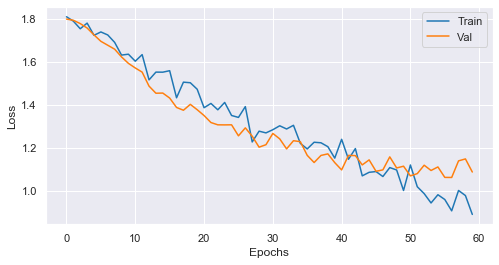

In [238]:
sns.set_palette('tab10', n_colors=2)
plt.figure(figsize=(8,4))

plt.plot(hist_1.history['loss'], label='Train')
plt.plot(hist_1.history['val_loss'], label='Val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

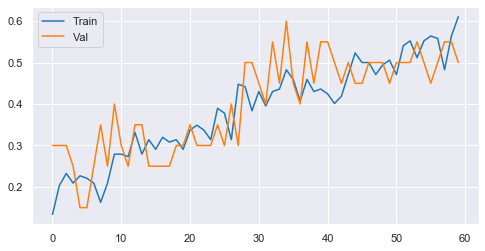

In [237]:
sns.set_palette('tab10', n_colors=2)
plt.figure(figsize=(8,4))

plt.plot(hist_1.history['accuracy'], label='Train', )
plt.plot(hist_1.history['val_accuracy'], label='Val')
plt.legend();

In [36]:
model.evaluate(Xtest_ss, y_test, verbose=0)

[1.2018617590268452, 0.5208333]

In [49]:
predictions = model.predict(Xtest_ss)

In [51]:
model.save("D1_subset_std_feats.h5")
model.save_weights("D1_subset_weights.h5")

In [24]:
Xtrain_ss.shape

(180, 53)

This model performed slightly better than MFCCs, and was significantly less overfit.  I played around with neurons and dropout layers a bit while add a few more than I had in the very first model since there are more features to learn.  It helped with accuracy a bit and definitely helped with overfitting.  Since I never evaluated the original model I don't know if that would have actually performed well on unseen data.